<a href="https://colab.research.google.com/github/jordanbell2357/uscg-nais-data/blob/main/ais_data_385301_uscg_vessel_minute_by_minute_total_presence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ais-data-385301' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=ais-data-385301:US:bquxjob_6479eb38_18957456353)
back to BigQuery to edit the query within the BigQuery user interface.

In [2]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_6479eb38_18957456353') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT * FROM `ais-data-385301.uscg.vessel_minute_by_minute_total_presence`;


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [3]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_6479eb38_18957456353') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,minute,total_vessel_count
0,2022-01-01 00:00:00+00:00,1607
1,2022-01-01 00:01:00+00:00,1776
2,2022-01-01 00:02:00+00:00,1961
3,2022-01-01 00:03:00+00:00,1948
4,2022-01-01 00:04:00+00:00,1900
...,...,...
524036,2022-12-31 23:55:00+00:00,1900
524037,2022-12-31 23:56:00+00:00,1941
524038,2022-12-31 23:57:00+00:00,1900
524039,2022-12-31 23:58:00+00:00,1902


In [4]:
df = results.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524041 entries, 0 to 524040
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   minute              524041 non-null  datetime64[ns, UTC]
 1   total_vessel_count  524041 non-null  Int64              
dtypes: Int64(1), datetime64[ns, UTC](1)
memory usage: 8.5 MB


In [7]:
df.head()

,total_vessel_count
minute,
2022-01-01 00:00:00+00:00,1607
2022-01-01 00:01:00+00:00,1776
2022-01-01 00:02:00+00:00,1961
2022-01-01 00:03:00+00:00,1948
2022-01-01 00:04:00+00:00,1900


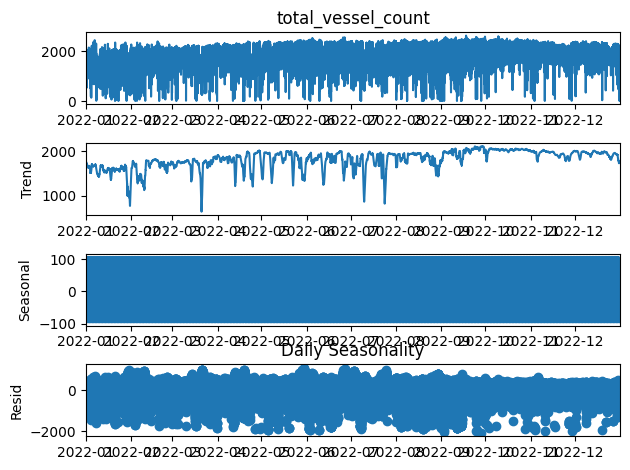

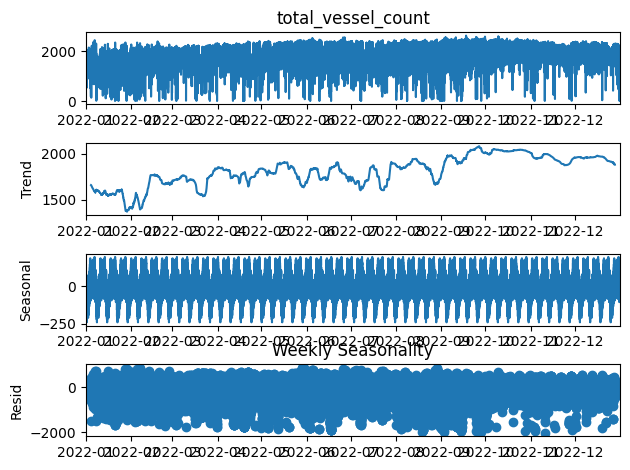

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decomposing for daily, weekly and yearly seasonality
result_daily = seasonal_decompose(df['total_vessel_count'], model='additive', period=24*60)  # minute data, so 24*60 minutes in a day
result_weekly = seasonal_decompose(df['total_vessel_count'], model='additive', period=24*60*7)  # 7 days in a week

# Plotting the decompositions
result_daily.plot()
plt.title('Daily Seasonality')
plt.show()

result_weekly.plot()
plt.title('Weekly Seasonality')
plt.show()

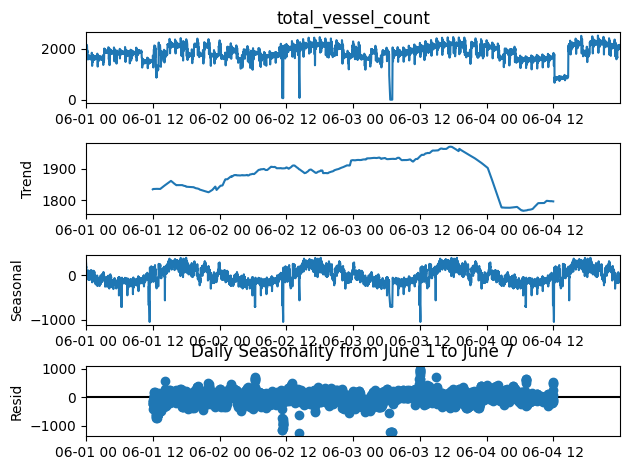

In [18]:
# Import necessary modules
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Subset data from June 1 to June 7
start_date = '2022-06-01 00:00:00+00:00'
end_date = '2022-06-04 23:59:59+00:00'
df_subset = df.loc[start_date:end_date]

# Perform the decomposition
result_daily_subset = seasonal_decompose(df_subset['total_vessel_count'], model='additive', period=24*60)  # minute data, so 24*60 minutes in a day

# Plot the decomposition
result_daily_subset.plot()
plt.title('Daily Seasonality from June 1 to June 7')
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c1v4p01/t7ln6p2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c1v4p01/gkbo5nlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41370', 'data', 'file=/tmp/tmp4c1v4p01/t7ln6p2t.json', 'init=/tmp/tmp4c1v4p01/gkbo5nlz.json', 'output', 'file=/tmp/tmp4c1v4p01/prophet_modelyyenjbpo/prophet_model-20230715031106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:11:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:11:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


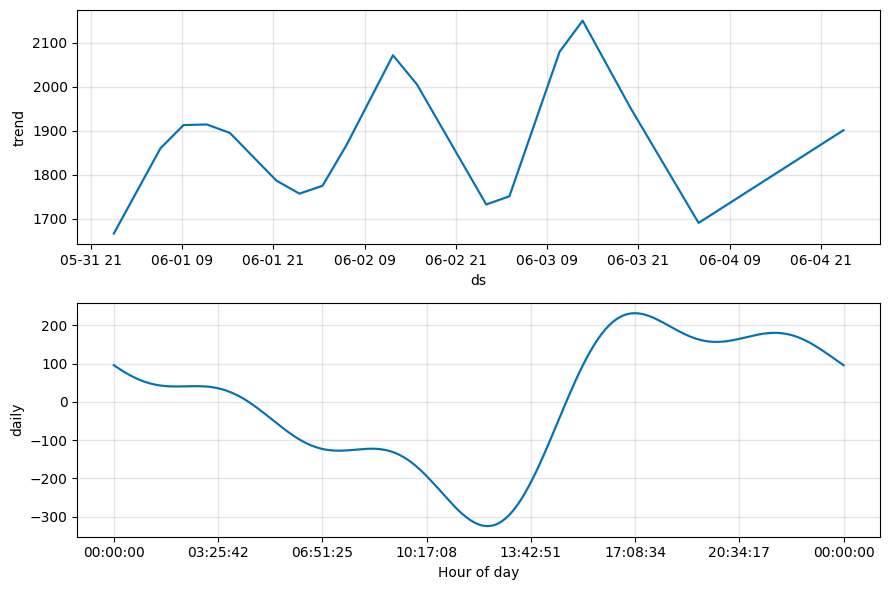

In [21]:
# Import necessary modules
from prophet import Prophet

df_subset_prophet = df_subset.reset_index().rename(columns={'minute': 'ds', 'total_vessel_count': 'y'})

# Convert the 'ds' column to naive timestamp
df_subset_prophet['ds'] = df_subset_prophet['ds'].dt.tz_localize(None)

# Initialize and fit the model
m = Prophet(daily_seasonality=True)
m.fit(df_subset_prophet)

# Predict on the training set itself to get the components
forecast = m.predict(df_subset_prophet)

# Plot the components
fig = m.plot_components(forecast)
